# Tuning LoRA Hyperparameters - Reproducing Tuning Results, Summary

## Environment Setup

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
%%capture
import sys
sys.path.append('src')

import boto3

import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import HyperparameterTuner

import warnings
warnings.filterwarnings('ignore')

from src.util import (
    count_parameters, 
    calc_combinations
)
from src.nb_helper import (
    display_tuning_jobs,
    get_default_estimator_parameters,
    p,
    capture_results,
    graph_results,
    roberta_total, 
    roberta_learnable
)
from amtviz import visualize_tuning_job
import altair as alt
sm = boto3.client('sagemaker')

## Experiments

Let's try some experiments. For all of the experiments we use one learning rate (and weight decay / dropout) as a basis. We use the learning rate we found with the tuning job.

In [3]:
# We continue to use the results of the base lora tuner
%store -r
assert base_lora_tuner_name
base_lora_tuner = HyperparameterTuner.attach(base_lora_tuner_name)
base_lora_tuner_name

'lora-base-tuning-231209-0038'

In [4]:
base_lora_tuner.wait()
desc = sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=base_lora_tuner.describe()['HyperParameterTuningJobName'])
print(desc['HyperParameterTuningJobName'], '=>', desc['HyperParameterTuningJobStatus'])
best_hyperparameters = desc['BestTrainingJob']['TunedHyperParameters']
print('Best parameters found:', best_hyperparameters)
best_hyperparameters = {k:float(v.replace('"', '')) for k, v in best_hyperparameters.items()}; best_hyperparameters

!
lora-base-tuning-231209-0038 => Completed
Best parameters found: {'sst2-epochs': '14', 'sst2-learning-rate': '0.001446695925631095'}


{'sst2-epochs': 14.0, 'sst2-learning-rate': 0.001446695925631095}

### Verify Reproducability

Let's pick a winning combination of hyperparameters and then validate that we weren't just lucky, but can repreatably produce sufficient results with those hyperparameter values.

It's up to us how small the adapters should become versus the performance we want to achieve. We have seen that we can roughly match the performance of the full-finetuning. In our case we needed a little bit more than one percent of the original parameters. With a larger model and exploiting the Intrinsic Dimension (see the first article) we would expect the percentage to go down a bit.

We will pick simple scenarios:
- All: We train adapters for all components on all laters with `r=8`.
- FF Up: We tune one adapter for each positionwise feed forward up projection with `r=16`, 12 in total, as we have 12 layers.

## Show comparisons with baseline here?

In [5]:
import concurrent.futures
import time

import traceback
import sys

# (r, conf)
combinations = [
    ( 1, 'all'),
    ( 4, 'all'),
    ( 8, 'all'),
    ( 8, 'ff_u'),
    ( 8, 'att_v+ff_u'),
]

def do_capture(r, conf):
    title = f'LoRA {conf}, r={r}'
    print(f'Submitting {title}')
    est = PyTorch(**get_default_estimator_parameters())
    est.set_hyperparameters(**{'sst2-lora-r': r, 'sst2-lora-config': conf, **best_hyperparameters})
    try:
        capture_results(title, est, job_name=f'{r}-{conf.replace("_", "-").replace("+", "-")}')
    except Exception: 
        print(traceback.format_exc())

executor = concurrent.futures.ThreadPoolExecutor(max_workers=4)
futures = [executor.submit(do_capture, *args) for args in combinations]

print('Waiting ...')
concurrent.futures.wait(futures)

Submitting LoRA all, r=1Submitting LoRA all, r=4

Submitting LoRA all, r=8
Submitting LoRA ff_u, r=8
Waiting ...
Using provided s3_resource
Using provided s3_resource
Using provided s3_resource
Using provided s3_resource
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
1,4.0,8-ff-u-231210-1417-004-1dd76002,Completed,2023-12-10 14:19:12+01:00,2023-12-10 14:39:30+01:00,1218.0,8-ff-u-231210-1417,0.946101
2,3.0,8-ff-u-231210-1417-003-e2102dca,Completed,2023-12-10 14:19:14+01:00,2023-12-10 14:39:32+01:00,1218.0,8-ff-u-231210-1417,0.942661
0,5.0,8-ff-u-231210-1417-005-a7ef05d3,Completed,2023-12-10 14:19:28+01:00,2023-12-10 14:39:43+01:00,1215.0,8-ff-u-231210-1417,0.940367
3,2.0,8-ff-u-231210-1417-002-fe78e944,Completed,2023-12-10 14:19:19+01:00,2023-12-10 14:39:35+01:00,1216.0,8-ff-u-231210-1417,0.940367
4,1.0,8-ff-u-231210-1417-001-d434fc6d,Completed,2023-12-10 14:19:08+01:00,2023-12-10 14:39:25+01:00,1217.0,8-ff-u-231210-1417,0.939220


Cache Hit/Miss: M.MM.MM.
Submitting LoRA att_v+ff_u, r=8
.Using provided s3_resource
.....................................................................................................................................................................................!
Tuning job 4-all-231210-1417         status: Completed

Number of training jobs with valid objective: 5
Lowest: 0.9426605701446533 Highest 0.9506880640983582


,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
2,2.0,4-all-231210-1417-003-327dc89d,Completed,2023-12-10 14:18:27+01:00,2023-12-10 14:44:44+01:00,1577.0,4-all-231210-1417,0.950688
4,0.0,4-all-231210-1417-001-8bbbf150,Completed,2023-12-10 14:18:40+01:00,2023-12-10 14:45:03+01:00,1583.0,4-all-231210-1417,0.947248
0,4.0,4-all-231210-1417-005-8da802ee,Completed,2023-12-10 14:18:26+01:00,2023-12-10 14:44:44+01:00,1578.0,4-all-231210-1417,0.943807
1,3.0,4-all-231210-1417-004-30f7ca96,Completed,2023-12-10 14:18:45+01:00,2023-12-10 14:45:03+01:00,1578.0,4-all-231210-1417,0.943807
3,1.0,4-all-231210-1417-002-efb8de44,Completed,2023-12-10 14:18:22+01:00,2023-12-10 14:44:55+01:00,1593.0,4-all-231210-1417,0.942661


Cache Hit/Miss: M.MM..MM
.!
.Tuning job 8-all-231210-1417         status: Completed

Number of training jobs with valid objective: 5
Lowest: 0.9415137767791748 Highest 0.9495412707328796


,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
4,0.0,8-all-231210-1417-001-e9cf4edb,Completed,2023-12-10 14:18:56+01:00,2023-12-10 14:45:16+01:00,1580.0,8-all-231210-1417,0.949541
3,1.0,8-all-231210-1417-002-161cad70,Completed,2023-12-10 14:18:45+01:00,2023-12-10 14:45:07+01:00,1582.0,8-all-231210-1417,0.947248
0,5.0,8-all-231210-1417-005-23ca00c8,Completed,2023-12-10 14:18:50+01:00,2023-12-10 14:45:03+01:00,1573.0,8-all-231210-1417,0.946101
2,2.0,8-all-231210-1417-003-78328b17,Completed,2023-12-10 14:18:27+01:00,2023-12-10 14:44:44+01:00,1577.0,8-all-231210-1417,0.944954
1,4.0,8-all-231210-1417-004-a8bfecb0,Completed,2023-12-10 14:18:50+01:00,2023-12-10 14:45:15+01:00,1585.0,8-all-231210-1417,0.941514


Cache Hit/Miss: MMMM!
Tuning job 1-all-231210-1417         status: Completed
M
Number of training jobs with valid objective: 5
Lowest: 0.9380733966827393 Highest 0.9472476840019226


,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
1,3.0,1-all-231210-1417-004-569051f1,Completed,2023-12-10 14:18:42+01:00,2023-12-10 14:45:00+01:00,1578.0,1-all-231210-1417,0.947248
3,1.0,1-all-231210-1417-002-7303e15f,Completed,2023-12-10 14:18:28+01:00,2023-12-10 14:44:41+01:00,1573.0,1-all-231210-1417,0.947248
4,0.0,1-all-231210-1417-001-77639e1e,Completed,2023-12-10 14:18:26+01:00,2023-12-10 14:44:39+01:00,1573.0,1-all-231210-1417,0.942661
2,2.0,1-all-231210-1417-003-96bec864,Completed,2023-12-10 14:18:36+01:00,2023-12-10 14:44:48+01:00,1572.0,1-all-231210-1417,0.941514
0,4.0,1-all-231210-1417-005-82d4b628,Completed,2023-12-10 14:18:46+01:00,2023-12-10 14:44:58+01:00,1572.0,1-all-231210-1417,0.938073



Cache Hit/Miss: M.MMMM
...................................................................................................................................................................................................................................................!
Tuning job 8-att-v-ff-u-231210-1443  status: Completed

Number of training jobs with valid objective: 5
Lowest: 0.9426605701446533 Highest 0.9518348574638367


,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
2,3.0,8-att-v-ff-u-231210-1443-003-65b26bba,Completed,2023-12-10 14:44:33+01:00,2023-12-10 15:06:05+01:00,1292.0,8-att-v-ff-u-231210-1443,0.951835
0,5.0,8-att-v-ff-u-231210-1443-005-ef51ac5a,Completed,2023-12-10 14:45:05+01:00,2023-12-10 15:06:51+01:00,1306.0,8-att-v-ff-u-231210-1443,0.949541
1,4.0,8-att-v-ff-u-231210-1443-004-f63a8b84,Completed,2023-12-10 14:44:20+01:00,2023-12-10 15:05:57+01:00,1297.0,8-att-v-ff-u-231210-1443,0.947248
3,1.0,8-att-v-ff-u-231210-1443-002-f423d692,Completed,2023-12-10 14:44:30+01:00,2023-12-10 15:06:02+01:00,1292.0,8-att-v-ff-u-231210-1443,0.942661
4,0.0,8-att-v-ff-u-231210-1443-001-0acbbc23,Completed,2023-12-10 14:44:28+01:00,2023-12-10 15:06:09+01:00,1301.0,8-att-v-ff-u-231210-1443,0.942661


Cache Hit/Miss: MMMMM


DoneAndNotDoneFutures(done={<Future at 0x2a256d660 state=finished returned NoneType>, <Future at 0x2a256d0f0 state=finished returned NoneType>, <Future at 0x2a24d0910 state=finished returned NoneType>, <Future at 0x2a256d180 state=finished returned NoneType>, <Future at 0x2a256e1d0 state=finished returned NoneType>}, not_done=set())

,target_tuner_name,title,objective_metric_mean,objective_metric_std,parameters_relative,train_speed_median,gpu_memory_max
0,capture-231209-0539,Full Finetuning,0.945872,0.002206,100.000000,909.390,98.500
1,capture-231209-0600,Classifier Only,0.824312,0.001495,0.475045,2376.222,12.275
2,capture-231209-0618,LoRA Base,0.946101,0.002689,1.539733,777.052,97.400
3,8-ff-u-231210-1417,"LoRA ff_u, r=8",0.941743,0.002738,0.770792,1099.295,92.300
4,4-all-231210-1417,"LoRA all, r=4",0.945642,0.003304,1.007389,776.417,97.700
5,8-all-231210-1417,"LoRA all, r=8",0.945872,0.002968,1.539733,776.485,97.400
6,1-all-231210-1417,"LoRA all, r=1",0.943349,0.003939,0.608131,778.259,97.700
7,8-att-v-ff-u-231210-1443,"LoRA att_v+ff_u, r=8",0.946789,0.004103,0.889090,1011.282,97.800


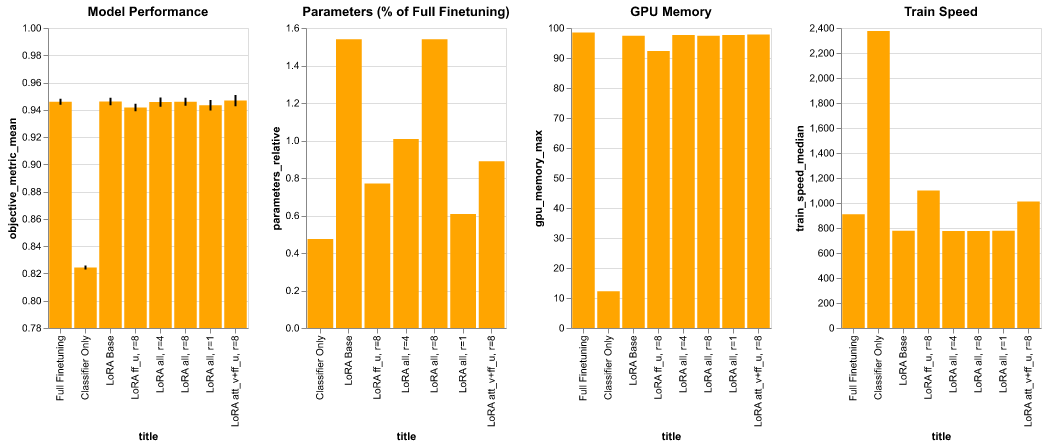

In [6]:
graph_results()

## Not considered

Given all the combinations possible there are many angles we could have pursuit, but limited ourselves to a smaller scope to keep things manageable and understandable. Amongst the angles not evaluated one stands out worth considering in the future: **Per-Adapter-R**. 

We see that on one hand the position-wise feed forward linear modules (`ff_up`, `ff_down` above) have more capacity than the linear modules used in attention. Assuming that they have been sized properly during pre-training, their larger capacity could also mean for fine-tuning that they can carry more information. It could be sensible then to use a higher rank than for the attention linear modules. On the other hand it could be that the specific finetuning task at hand is different enough from pre-training, that the original sizing is not appropriate and, here again, you can pick a specific r for specific modules, say the query linear modules that are close to the task head.

It may also be a good idea to evaluate if applying a non-uniform pattern may be more helpful. Right now we are applying one pattern uniformely, but we could also imagine applying an adaptation of `att_v` for every even layer and the adaptation of `ff_u` for every odd layer.
